## 0. Library & Dataset Import

In [1]:
!pip install mglearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# default
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# nlp (tokenizing, normalization, stopwords)
import nltk
from nltk.corpus import stopwords

# Random Forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV

# SVM
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
import mglearn

# Evaluation Performance
from sklearn import metrics
from sklearn.metrics import accuracy_score, recall_score, classification_report, f1_score

In [3]:
nltk.download('book')

[nltk_data] Downloading collection 'book'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package brown to /root/nltk_data...
[nltk_data]    |   Package brown is already up-to-date!
[nltk_data]    | Downloading package chat80 to /root/nltk_data...
[nltk_data]    |   Package chat80 is already up-to-date!
[nltk_data]    | Downloading package cmudict to /root/nltk_data...
[nltk_data]    |   Package cmudict is already up-to-date!
[nltk_data]    | Downloading package conll2000 to /root/nltk_data...
[nltk_data]    |   Package conll2000 is already up-to-date!
[nltk_data]    | Downloading package conll2002 to /root/nltk_data...
[nltk_data]    |   Package conll2002 is already up-to-date!
[nltk_data]    | Downloading package dependency_treebank to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package dependency_treebank is already up-to-date!
[nltk_data]    | Downloadi

True

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
data = pd.read_csv('/content/drive/MyDrive/MBTI 500.csv', encoding='UTF-8')
USER_SAMPLE = 1

In [6]:
# Sampling
if USER_SAMPLE :
    data = data.groupby('type').sample(frac = 0.05)
data.reset_index(drop = True, inplace = True)

## 1. EDA

In [7]:
data.head()

,posts,type
0,tertiary function fe incline lot lack good wor...,ENFJ
1,responsibility get emotionally involve help al...,ENFJ
2,one engage ti jiujitsu rock climb obstacle cou...,ENFJ
3,nikka extremely attract esfj would love date i...,ENFJ
4,develop really empathetic character would like...,ENFJ


In [8]:
data.isnull().sum()

posts    0
type     0
dtype: int64

In [9]:
data = data.rename(columns={'type' : 'mbti'})

In [10]:
# 포스팅별 단어 개수
data['length'] = data['posts'].apply(lambda x : len(x.split(' ')))
data['length'].describe()

count    5302.000000
mean      500.021501
std         1.184980
min       480.000000
25%       500.000000
50%       500.000000
75%       500.000000
max       522.000000
Name: length, dtype: float64

In [11]:
data.head()

,posts,mbti,length
0,tertiary function fe incline lot lack good wor...,ENFJ,502
1,responsibility get emotionally involve help al...,ENFJ,499
2,one engage ti jiujitsu rock climb obstacle cou...,ENFJ,502
3,nikka extremely attract esfj would love date i...,ENFJ,499
4,develop really empathetic character would like...,ENFJ,498


In [12]:
data.dtypes

posts     object
mbti      object
length     int64
dtype: object

## 2.  Dataset Pre-processing

In [13]:
# Target Column Labeling
# Case4: E vs I , N vs S , F vs T , P vs J

data['mbti'].replace(['ESTP', 'ESTJ', 'ESFP', 'ESFJ', 'ENTP', 'ENTJ', 'ENFP', 'ENFJ'], 'E', inplace=True)
data['mbti'].replace(['ISTP', 'ISTJ', 'ISFP', 'ISFJ', 'INTP', 'INTJ', 'INFP', 'INFJ'], 'I', inplace=True)
data.head()

,posts,mbti,length
0,tertiary function fe incline lot lack good wor...,E,502
1,responsibility get emotionally involve help al...,E,499
2,one engage ti jiujitsu rock climb obstacle cou...,E,502
3,nikka extremely attract esfj would love date i...,E,499
4,develop really empathetic character would like...,E,498


In [14]:
data['mbti'].unique()

array(['E', 'I'], dtype=object)

In [15]:
# posts 컬럼의 단어 추출
words = list()

for i in list(data['posts']):
  for j in i.split(' '):
    words.append(j)

In [16]:
words[:10]

['tertiary',
 'function',
 'fe',
 'incline',
 'lot',
 'lack',
 'good',
 'word',
 'give',
 'add']

In [17]:
len(words)

2651114

In [18]:
# mbti 단어를 stopwords로 지정, posts 컬럼 정제
my_stopwords = {'estp', 'estj', 'esfp', 'esfj', 'entp', 'entj', 'enfp', 'enfj', 'istp', 'istj', 'isfp', 'isfj', 'intp', 'intj', 'infp', 'infj'}

words = [i for i in words if i not in my_stopwords]
words[:10]

['tertiary',
 'function',
 'fe',
 'incline',
 'lot',
 'lack',
 'good',
 'word',
 'give',
 'add']

In [19]:
len(words)

2618578

In [20]:
# 단어별 빈도수 계산
words_dic = Counter(words)
words_dic = pd.DataFrame({'Word':list(words_dic.keys()), 'Frequency':list(words_dic.values())})

# 빈도수 내림차순 정렬된 데이터프레임 생성
words_dic.sort_values('Frequency', ascending=False, inplace=True)
words_dic.set_index('Word', inplace=True)

print(len(words_dic))
words_dic.head()

50933


,Frequency
Word,
like,34489
think,29657
people,27533
get,26642
make,20225


In [21]:
# 단어별 빈도수 분포 확인
words_dic['Frequency'].describe()

count    50933.000000
mean        51.412208
std        508.642920
min          1.000000
25%          1.000000
50%          2.000000
75%          7.000000
max      34489.000000
Name: Frequency, dtype: float64

Q1 = 1.0
Q3 = 7.0
IQR = 6.0
Q2 = 2.0
Q4 = 34489.0


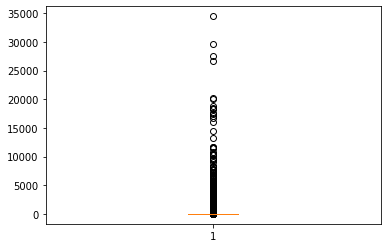

In [22]:
plt.boxplot(words_dic['Frequency'])

Q1 = words_dic['Frequency'].quantile(.25)
Q3 = words_dic['Frequency'].quantile(.75)
IQR = Q3 - Q1
Q2 = words_dic['Frequency'].quantile(.5)
Q4 = words_dic['Frequency'].quantile(1)

print("Q1 =",Q1)
print("Q3 =",Q3)
print("IQR =",IQR)
print("Q2 =",Q2)
print("Q4 =",Q4)

In [23]:
start = np.arange(0, 1, 0.1)
end = np.arange(0.91, 1, 0.01)

In [24]:
# 4분위수 범위 더 좁혀보기
for i in start:
    print(words_dic['Frequency'].quantile(i))

1.0
1.0
1.0
1.0
1.0
2.0
2.0
5.0
10.0
36.0


In [25]:
for i in end:
    print(words_dic['Frequency'].quantile(i))

43.0
53.0
67.0
87.0
113.0
159.72000000000844
237.0
420.0800000000236
945.0


In [26]:
words_dic = words_dic[words_dic.Frequency > 3000]
len(words_dic)
# 각 MBTI 포스팅개수 간의 편차가 크므로, 
# 모든 MBTI에 출현했을 확률이 높은, 높은 빈도수의 단어를 추출

144

In [27]:
mode_words = list(words_dic.index)

for i in mode_words:
    data[i] = data['posts'].apply(lambda x : 1 if i in x.split(' ') else 0)

data.drop(['length','posts'],axis=1,inplace=True)
data.head()

,mbti,like,think,people,get,make,thing,know,feel,one,...,word,le,wrong,fi,least,big,enjoy,call,tend,game
0,E,1,1,0,1,1,1,1,1,1,...,1,0,0,0,0,1,0,0,1,0
1,E,1,1,1,1,1,1,1,1,0,...,1,0,1,1,0,1,0,1,0,1
2,E,1,1,1,1,1,1,1,1,1,...,0,0,1,0,0,0,1,0,0,1
3,E,1,1,1,1,1,1,1,1,1,...,0,1,0,0,0,0,1,1,1,0
4,E,1,1,1,1,1,1,1,1,1,...,1,0,1,1,1,1,1,0,0,0


In [28]:
len(data)

5302

In [29]:
# mbti에 따른 단어별 평균 출현 비율 계산
data2 = data.groupby('mbti').mean()
data2 = data2.transpose()
data2.head()

mbti,E,I
like,0.993696,0.993801
think,0.988968,0.989338
people,0.982664,0.977684
get,0.987392,0.984379
make,0.969267,0.972477


## 3. Random Forest Classification Model
### 하이퍼파라미터 튜닝, Grid-SearchCV

* [Feature Importance](https://soohee410.github.io/iml_tree_importance)

* Random Forest Classifier Hyperparameters
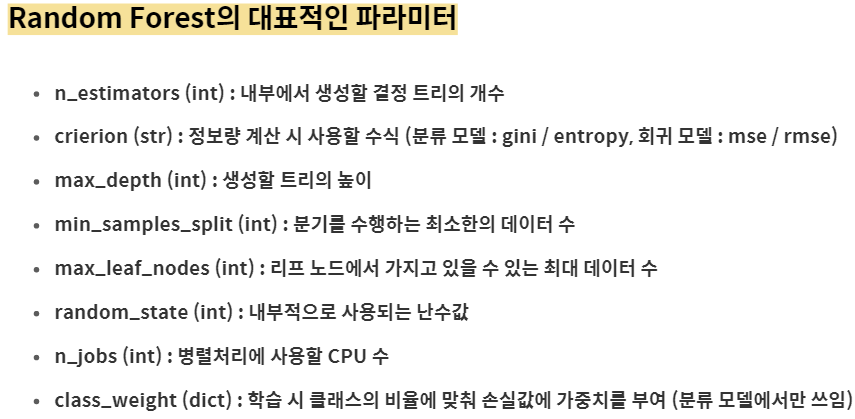

* GridSearchCV Hyperparameters
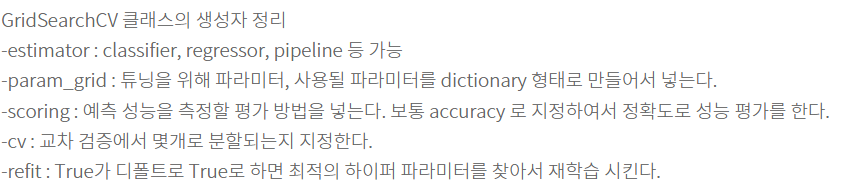

  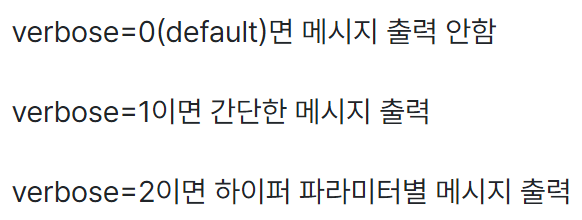

In [30]:
# 중요한 속성을 추출하기 위한 데이터프레임 생성
Feature_Importance = pd.DataFrame()

In [31]:
temp = data.copy()

# MBTI One-Hot Encoding
temp['mbti'] = temp['mbti'].apply(lambda x : 1 if x=='E' else 0)
temp['mbti'].unique()

array([1, 0])

In [32]:
# train-test split
X = temp.drop('mbti', axis=1)
y = temp['mbti']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [33]:
rf = RandomForestClassifier(random_state=10, n_jobs=-1, class_weight='balanced')

In [34]:
# Grid Search
params = {'n_estimators':[50, 100],
            'max_depth':[3,5,7,10,12,15],
            'max_features':[0.05, 0.1, 0.15, 0.2],
            'criterion':['gini', 'entropy']}

grid_cv = GridSearchCV(estimator=rf, param_grid=params, verbose=1, n_jobs=-1, scoring='accuracy')
grid_cv.fit(X_train, y_train)

Fitting 5 folds for each of 96 candidates, totalling 480 fits


GridSearchCV(estimator=RandomForestClassifier(class_weight='balanced',
                                              n_jobs=-1, random_state=10),
             n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [3, 5, 7, 10, 12, 15],
                         'max_features': [0.05, 0.1, 0.15, 0.2],
                         'n_estimators': [50, 100]},
             scoring='accuracy', verbose=1)

In [35]:
print('최적 하이퍼 파라미터:\n', grid_cv.best_params_)
print('최고 예측 정확도: {0:.4f}'.format(grid_cv.best_score_))

rf_best = grid_cv.best_estimator_ # 최적의 모델 도출

최적 하이퍼 파라미터:
 {'criterion': 'entropy', 'max_depth': 10, 'max_features': 0.2, 'n_estimators': 100}
최고 예측 정확도: 0.7656


In [36]:
# Prediction
y_train_pred = rf_best.predict(X_train)
y_test_pred = rf_best.predict(X_test)

print('Train Accuracy : ', accuracy_score(y_train, y_train_pred))
print('Test Accuracy : ', accuracy_score(y_test, y_test_pred))

Train Accuracy :  0.9992926196651734
Test Accuracy :  0.7445805843543827


In [37]:
target_ls = ['E', 'I']

In [38]:
for i in target_ls:
  temp = data.copy()
  # MBTI One-Hot Encoding
  temp['mbti'] = temp['mbti'].apply(lambda x : 1 if x=='E' else 0) 

  # train-test split
  X = temp.drop('mbti', axis=1)
  y = temp['mbti']
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

  rf = RandomForestClassifier(random_state=10, n_jobs=-1, class_weight='balanced')

  params = {'n_estimators':[100],
            'max_depth':[3,5,7,10,12,15],
            'max_features':[0.05, 0.1, 0.15, 0.2],
            'criterion':['gini', 'entropy']}

  # Grid Search
  grid_cv = GridSearchCV(estimator=rf, param_grid=params, verbose=1, n_jobs=-1, scoring='accuracy')
  grid_cv.fit(X_train, y_train)

  rf_best = grid_cv.best_estimator_ # 최적의 모델 도출
  print('최적 하이퍼 파라미터:\n', grid_cv.best_params_)
  print('최고 예측 정확도: {0:.4f}'.format(grid_cv.best_score_))

  # Prediction
  y_train_pred = rf_best.predict(X_train)
  y_test_pred = rf_best.predict(X_test)
  
  print('Train Accuracy : ', accuracy_score(y_train, y_train_pred))
  print('Test Accuracy : ', accuracy_score(y_test, y_test_pred))

  # 중요 속성(=단어) 출력
  Feature_Importance['Feature'] = X_train.columns
  Feature_Importance[i] = rf_best.feature_importances_

Fitting 5 folds for each of 48 candidates, totalling 240 fits
최적 하이퍼 파라미터:
 {'criterion': 'entropy', 'max_depth': 10, 'max_features': 0.2, 'n_estimators': 100}
최고 예측 정확도: 0.7656
Train Accuracy :  0.9992926196651734
Test Accuracy :  0.7445805843543827
Fitting 5 folds for each of 48 candidates, totalling 240 fits
최적 하이퍼 파라미터:
 {'criterion': 'entropy', 'max_depth': 10, 'max_features': 0.2, 'n_estimators': 100}
최고 예측 정확도: 0.7656
Train Accuracy :  0.9992926196651734
Test Accuracy :  0.7445805843543827


In [39]:
# 도출한 최적의 하이퍼파라미터를 바탕으로 중요 피쳐 시각화

## Support Vector Machine Model

### TfidVectorizer
TfidVectorizer calculates an inverse frequency for each word.

It converts a collection of raw documents to a matrix of TF-IDF features.

### References
https://en.wikipedia.org/wiki/Support-vector_machine https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html#sklearn.svm.LinearSVC

### Model Pipeline
A pipelined model ir order to facilitate the entire process of CountVectorizer (TfidfVectorizer) and svm.LinearSVC model

In [40]:
# Dataset Reload
data = pd.read_csv('/content/drive/MyDrive/MBTI 500.csv', encoding='UTF-8')
USER_SAMPLE = 1
# Sampling
if USER_SAMPLE :
    data = data.groupby('type').sample(frac = 0.05)
data.reset_index(drop = True, inplace = True)

data.head()

,posts,type
0,sign get dress go work hard class follow instr...,ENFJ
1,lot reflection get walk outgrow martyr complex...,ENFJ
2,associate high ti xntps lot intellectual willp...,ENFJ
3,want see zombie courtesan costume well two fri...,ENFJ
4,deep personal mean use idea come real life pla...,ENFJ


In [41]:
data = data.rename(columns={'type' : 'mbti'})

In [42]:
data['mbti'].replace(['ESTP', 'ESTJ', 'ESFP', 'ESFJ', 'ENTP', 'ENTJ', 'ENFP', 'ENFJ'], 'E', inplace=True)
data['mbti'].replace(['ISTP', 'ISTJ', 'ISFP', 'ISFJ', 'INTP', 'INTJ', 'INFP', 'INFJ'], 'I', inplace=True)
data.head()

,posts,mbti
0,sign get dress go work hard class follow instr...,E
1,lot reflection get walk outgrow martyr complex...,E
2,associate high ti xntps lot intellectual willp...,E
3,want see zombie courtesan costume well two fri...,E
4,deep personal mean use idea come real life pla...,E


In [43]:
# mbti 단어를 stopwords로 지정, posts 컬럼 정제
# stopwords = nltk.corpus.stopwords.words('english')
# my_stopwords = ['estp', 'estj', 'esfp', 'esfj', 'entp', 'entj', 'enfp', 'enfj', 'istp', 'istj', 'isfp', 'isfj', 'intp', 'intj', 'infp', 'infj']
# stopwords.extend(my_stopwords)

# data['mbti'] = data['mbti'].apply(lambda x : [item for item in x if item not in stopwords])

In [44]:
# train-test split
X = data['posts'] # features
y = data['mbti']  # labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [45]:
# Create an Instance to Vectorizer
vectorizer = TfidfVectorizer()

In [46]:
# training the vectorizer
X_train_tfidf = vectorizer.fit_transform(X_train)

In [47]:
# training the classifier
svm = LinearSVC()
svm.fit(X_train_tfidf, y_train)

LinearSVC()

In [48]:
# Pipelining the Vectorizer and Classifier
clf = Pipeline([('tfidf', TfidfVectorizer()), ('clf', LinearSVC())])
clf.fit(X_train, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', LinearSVC())])

In [49]:
# prediction
prediction = clf.predict(X_test)

In [50]:
print(classification_report(y_test, prediction))

              precision    recall  f1-score   support

           E       0.88      0.61      0.72       271
           I       0.88      0.97      0.92       790

    accuracy                           0.88      1061
   macro avg       0.88      0.79      0.82      1061
weighted avg       0.88      0.88      0.87      1061



In [51]:
print(f"Overall accuracy of the model: {round(metrics.accuracy_score(y_test, prediction),2)}")

Overall accuracy of the model: 0.88


In [52]:
# mglearn Chart 그리기